### 데이터 읽어오기 
Riiid 데이터는 pickle형태로 /opt/ml/input/data/RIIID에 따로 저장해준다.

#### 학습 구성 파일
* [pickle] riiid_train.pkl.gzip
* [csv] questions.csv
* [csv] lectures.csv

In [117]:
import os, sys
import time
from datetime import datetime
import random

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F 
try:
    from transformers.modeling_bert import BertConfig, BertEncoder, BertModel    
except:
    from transformers.models.bert.modeling_bert import BertConfig, BertEncoder, BertModel    

import copy
import math

import easydict
import tqdm

DRIVE_PATH = "/opt/ml"
DATA_PATH = "/opt/ml/input/data/RIIID"
file_name = "riiid_train.pkl.gzip"
config = {}

# 설정
config['seed'] = 42
config['device'] = "cuda" if torch.cuda.is_available() else "cpu"
config['data_dir'] = DATA_PATH
config['asset_dir'] = os.path.join(DRIVE_PATH, 'code/asset')
config['model_dir'] = os.path.join(DRIVE_PATH, 'models')
config['model_name'] = 'model.pt'
config['output_dir'] = os.path.join(DRIVE_PATH, 'outputs')

# 데이터
config['max_seq_len'] = 20
config['num_workers'] = 1


# 모델
config['hidden_dim'] = 64
config['n_layers'] = 2
config['dropout'] = 0.2

# 훈련
config['n_epochs'] = 20
config['batch_size'] = 64
config['lr'] = 0.0001
config['clip_grad'] = 10
config['log_steps'] = 50
config['patience'] = 5



### 중요 ###
config['model'] = 'lstm'
config['optimizer'] = 'adam'
config['scheduler'] = 'plateau'


args = easydict.EasyDict(config)    

In [118]:
import pandas as pd

train_df = pd.read_pickle(os.path.join(args.data_dir, 'riiid_train.pkl.gzip'))
questions_df = pd.read_csv(os.path.join(args.data_dir, 'questions.csv'))
lectures_df = pd.read_csv(os.path.join(args.data_dir, 'lectures.csv'))

In [119]:
train_df = train_df.iloc[:int(1e7)+1,:]

In [120]:
# remove lecture type row 
train_df = train_df[train_df['content_type_id'] != 1]

### 📗 EDA (Exploratory Data Analysis)
> 간단하게 데이터를 살펴보면서 이 데이터를 어떻게 하면 Transformer input으로 바꿀 수 있을지 생각해보자!

In [121]:
train_df.sample(5)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
7784811,7784811,4152318007,169433648,2357,False,227,2,1,27000.0,True
9838001,9838001,29558987479,213573510,894,False,821,3,1,18000.0,True
943892,943892,2419052454,19594546,7068,False,1060,3,1,35500.0,True
5165340,5165340,865702930,110773765,7602,False,2349,2,1,43400.0,True
6034381,6034381,542217101,129795932,4831,False,29,1,1,31000.0,True


In [122]:
lectures_df.sample(5)

,lecture_id,tag,part,type_of
80,7097,13,1,solving question
129,10928,136,3,solving question
89,8138,151,6,concept
372,29695,27,6,concept
293,23262,66,5,concept


In [123]:
questions_df.sample(5)

,question_id,bundle_id,correct_answer,part,tags
755,755,755,1,2,143 71 81 92
3317,3317,3315,2,4,136 12 92
3258,3258,3258,2,4,136 67 38
7599,7599,7599,3,7,97 37 21
11812,11812,11812,3,4,136 81 59


#### 🟡 데이터셋으로 사용될 각 sequence들의 indices목록 생성
> 우리는 transformer input으로 sequence 데이터를 주어야 하기에 현재 pandas DataFrame을 sequence 데이터로 바꾸어야 한다. 이 sequence 데이터로 변환하는 것은 추후 Dataset이 수행할 것이고 **우리는 각 sequence 데이터가 이 pandas DataFrame의 어떤 indices의 데이터들을 결합해서 만들 것인지 목록을 생성**해야 한다.

In [124]:
# 문제 푸는 데이터들의 index
question_bool = train_df['content_type_id'] == 0

# 학습 과정에서 학습 샘플을 생성하기 위해서 필요한 유저별 row_ids를 저장
question_row_ids_by_user_id = train_df[question_bool].groupby('user_id').apply(lambda x: x['row_id'].values)
question_row_ids_by_user_id.reset_index().sample(5)

,user_id,0
19864,108615840,"[5072371, 5072372, 5072373, 5072374, 5072375, ..."
29335,161204474,"[7432163, 7432164, 7432165, 7432166, 7432167, ..."
32451,178288107,"[8199463, 8199464, 8199465, 8199466, 8199467, ..."
14096,76849752,"[3570490, 3570491, 3570492, 3570493, 3570494, ..."
9240,50427074,"[2347735, 2347736, 2347737, 2347738, 2347739, ..."


In [125]:
# 학습 과정에서 학습 샘플을 생성하기 위해서 필요한 유저별 시작 row_id를 저장
start_row_id_by_user_id = train_df.groupby('user_id').apply(lambda x: x['row_id'].values[0])
start_row_id_by_user_id.reset_index().sample(5)

,user_id,0
3324,18066275,861157
10598,57764310,2641979
38532,211631374,9729627
13707,74647908,3469218
20104,109907841,5119212


#### 🟡 questions_df / lectures_df wrangling
> 데이터셋을 우리가 원하는 형태의 데이터셋으로 바꿔가는 wrangling은 언제나 필수적인 요소다.우리는 여기서 데이터셋을 다듬고 `questions_df`와 `lectures_df`를 하나로 합칠 것이다.

- column 이름 변경
- NaN 값 채우기
- 데이터 타입 변경
- 필요없는 column 삭제
- 새로운 feature 생성
- 데이터셋 합치기

In [126]:
# column 이름 변경
questions_df = questions_df.rename({'question_id':'content_id'}, axis=1)
lectures_df = lectures_df.rename({'lecture_id':'content_id', 'tag':'tags'}, axis=1)

# NaN값 채우기
questions_df['tags'] = questions_df['tags'].fillna('')        

# 데이터 타입 변경
lectures_df['tags'] = lectures_df['tags'].astype(str)

# 필요없는 column 삭제
questions_df = questions_df.drop('bundle_id', axis=1)

# 새로운 feature 생성
questions_df['content_type_id'] = 0
lectures_df['content_type_id'] = 1

# 데이터셋 합치기
question_lectures_df = pd.concat([questions_df, lectures_df])

In [127]:
questions_df.head(3)

,content_id,correct_answer,part,tags,content_type_id
0,0,0,1,51 131 162 38,0
1,1,1,1,131 36 81,0
2,2,0,1,131 101 162 92,0


In [128]:
lectures_df.head(3)

,content_id,tags,part,type_of,content_type_id
0,89,159,5,concept,1
1,100,70,1,concept,1
2,185,45,6,concept,1


In [129]:
# 합쳐진 데이터셋 확인
question_lectures_df.head(3)

,content_id,correct_answer,part,tags,content_type_id,type_of
0,0,0.0,1,51 131 162 38,0,NaN
1,1,1.0,1,131 36 81,0,NaN
2,2,0.0,1,131 101 162 92,0,NaN


#### 🟡 데이터셋 합치기
> 위에서 만든 `questions_lectures_df`를 `train_df`에 합치자!

In [130]:
train_df = train_df.merge(question_lectures_df, how='left', on=['content_id', 'content_type_id']) 

In [131]:
train_df.sample(3)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,correct_answer,part,tags,type_of
5812750,5927802,27648030420,127730967,4163,False,1723,1,0,20000.0,True,0.0,5,79,NaN
6996983,7136331,1180500891,155120014,1582,False,268,1,1,27666.0,True,1.0,3,157 92 29,NaN
1950255,1989027,112525386,41894694,335,False,35,1,0,17000.0,True,0.0,2,2 107 162 92 29,NaN


#### 🟡 Category to index 생성 및 mapping
> 데이터셋을 embedding하기 위해서는 범주형(category) feature들을 숫자로 변환할 필요가 있다. 이를 위해서 우리는 각 범주형 feature마다 `cate2idx`을 만들고 mapping을 할 것이다.

In [132]:
cate2id_dict = {}

# 0은 nan이 사용한다
offset = 1

# type2id
type2id = dict([(v, i+offset) for i, v in enumerate(lectures_df['type_of'].unique())])
cate2id_dict['type2id'] = type2id
offset += len(type2id)

# part2id
part2id = dict([(v, i+offset) for i, v in enumerate(lectures_df['part'].unique())])
cate2id_dict['part2id'] = part2id
offset += len(part2id)
        
# tags2id
tags2id = dict([(v, i+offset) for i, v in enumerate(pd.concat([questions_df['tags'], lectures_df['tags']]).unique())])
cate2id_dict['tags2id'] = tags2id
offset += len(tags2id)

# # lec_content2id
# lec_content2id = dict([(v, i+offset) for i, v in enumerate(lectures_df['content_id'].unique())])
# cate2id_dict['lec_content2id'] = lec_content2id
# offset += len(lec_content2id)

# qu_content2id
qu_content2id = dict([(v, i+offset) for i, v in enumerate(questions_df['content_id'].unique())])
cate2id_dict['qu_content2id'] = qu_content2id
offset += len(qu_content2id)

# container2id
task_2id = dict([(v, i+offset) for i, v in enumerate(train_df['task_container_id'].unique())])
cate2id_dict['task_2id'] = task_2id 
offset += len(task_2id)
print(offset)

25131


In [133]:
cate2id_dict.keys()

dict_keys(['type2id', 'part2id', 'tags2id', 'qu_content2id', 'task_2id'])

In [134]:
cate2id_dict['part2id']

{5: 5, 1: 6, 6: 7, 2: 8, 7: 9, 3: 10, 4: 11}

In [135]:
import numpy as np

for dict_key, dict_value in cate2id_dict.items():
    np.save(os.path.join(args.asset_dir, dict_key + '_classes.npy'), list(dict_value.keys()))

In [136]:
# mapping
question_bool = train_df['content_type_id'] == 0
train_df.loc[question_bool, 'content_id'] = train_df.loc[question_bool, 'content_id'].map(qu_content2id)
# train_df.loc[~question_bool, 'content_id'] = train_df.loc[~question_bool, 'content_id'].map(lec_content2id)

train_df['task_container_id'] = train_df['task_container_id'].map(task_2id)
train_df['type_of'] = train_df['type_of'].map(type2id)
train_df['part'] = train_df['part'].map(part2id)
train_df['tags'] = train_df['tags'].map(tags2id)
train_df['type_of'] = train_df['type_of'].fillna(0).astype(np.int32)

In [137]:
train_df.sample(3)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,correct_answer,part,tags,type_of
5461910,5570720,1055719963,119192119,3727,False,15282,0,0,17000.0,True,3.0,10,571,0
4135298,4217960,1022045980,89504683,5820,False,15584,0,0,44000.0,True,3.0,5,1023,0
6135374,6256697,1809087896,134888946,3808,False,16186,3,1,24666.0,True,3.0,10,610,0


In [138]:
train_df = train_df.drop(['content_type_id'], axis=1)

In [139]:
train_df.sample(5)

,row_id,timestamp,user_id,content_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,correct_answer,part,tags,type_of
267753,272916,1732137152,5243685,9357,15807,0,0,13333.0,True,2.0,9,1325,0
4952779,5051687,1565626557,108064542,8482,15247,2,0,15000.0,False,3.0,7,1114,0
8630322,8802668,172094126,191624533,9936,15162,0,0,51000.0,True,1.0,5,1048,0
5449780,5558411,4150274328,118752844,10856,15217,0,1,7000.0,True,0.0,5,1053,0
9598922,9790658,12528580127,212874547,3205,16002,2,0,32500.0,False,0.0,10,537,0


#### 🟡 특성 공학 (Feature Engineering)
> 우리의 학습을 더욱 쉽게 하기 위한 새로운 feature들을 생성하자! 주로 수치형 feature를 생성한다

- `correct_answer` NaN값 채우기
- `timestamp` 시간 단위 초로 변경하기
- `lag_time` 생성
- `prior_questions` 관련 column 처리
- `정확도 (accuracy)` feature 생성
- `상대적 (relative)` feature 생성
- `과거 (prior)` feature 생성
- `바로전 (previous)` feature 생성

##### `correct_answer` NaN값 채우기
> feature engineering에 속하지는 않지만 겸사겸사 진행한다

In [140]:
# 237개의 nan값이 존재한다
train_df['correct_answer'].isna().sum()

0

In [141]:
train_df['correct_answer'] = train_df['correct_answer'].fillna(-1).astype(np.int16)

##### `timestamp` 시간 단위 초로 변경하기

In [142]:
train_df['timestamp'] = (train_df['timestamp'] / 1e03).astype(np.int32)
train_df['timestamp'][10]

255

##### `lag_time` 생성

In [143]:
train_df['lag_time'] = train_df['timestamp'].diff().fillna(0)
train_df['lag_time'][:3]

0     0.0
1    56.0
2    62.0
Name: lag_time, dtype: float64

##### `prior_questions` 관련 column 처리
- `prior_question_elapsed_time` : nan값 채우기와 시간 단위 초로 변경
- `prior_question_had_explanation` : nan값 채우기

In [144]:
train_df['prior_question_elapsed_time'] = train_df['prior_question_elapsed_time'].fillna(0) / 1e03
train_df['prior_question_had_explanation'] = train_df['prior_question_had_explanation'].fillna(0).astype(np.int32)

#### 🟡 트랜스폼 (Transform)
> 로그 스케일링! skew한 분포를 normal 분포로!

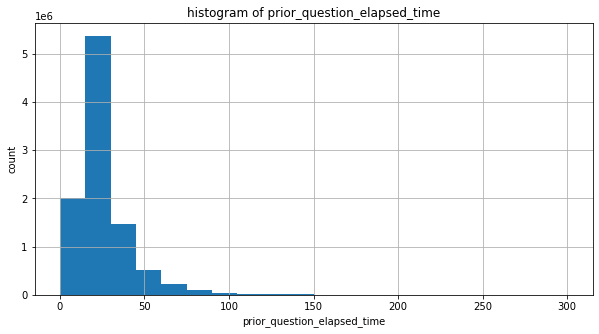

In [145]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
train_df['prior_question_elapsed_time'].hist(bins=20)

plt.grid('False')
plt.title('histogram of prior_question_elapsed_time')
plt.xlabel('prior_question_elapsed_time');
plt.ylabel('count');

In [146]:
import numpy as np

log1p_cols = ['timestamp',
              'prior_question_elapsed_time',
            #   'prior_part_frequency',
            #   'prior_tags_frequency',
            #   'prior_content_id_frequency',
#               'diff_time_btw_content_ids',
              'lag_time']

train_df[log1p_cols] = np.log1p(train_df[log1p_cols])

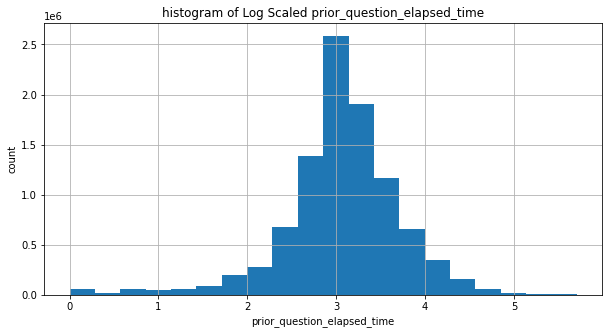

In [147]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
train_df['prior_question_elapsed_time'].hist(bins=20)

plt.grid('False')
plt.title('histogram of Log Scaled prior_question_elapsed_time')
plt.xlabel('prior_question_elapsed_time');
plt.ylabel('count');

#### 🟡 범주형 / 수치형 feature 데이터 타입 변환

In [148]:
cont_cols = ['timestamp',
             'prior_question_elapsed_time',
             'prior_question_had_explanation',
             'lag_time',
             'answered_correctly']

cate_cols = ['content_id', 'task_container_id', 'tags', 'type_of', 'part'] 

train_df[cate_cols] = train_df[cate_cols].astype(np.int16)
train_df[cont_cols] = train_df[cont_cols].astype(np.float32)     

#### 🟡 전처리가 끝나고 우리에게 남은 것
> 긴 전처리 과정이 끝나고 3개의 pandas DataFrame에서 출발하여 우리는 훈련에 필요한 데이터들을 얻었다. 이는 다음과 같다.

- `train_df` : 핵심 훈련 데이터. feature engineering을 통해 feature수가 많이 증가했다.
- `cate2id_dict` : 각 범주형 feature를 embedding이 가능하도록 index로 바꿔주는 dictionary

**column 이름**
- `offset` : 범주형 feature들의 값들의 총 갯수
- `cate_cols` : 범주형 feature들의 column 이름
- `cont_cols` : 수치형 feature들의 column 이름

**훈련 데이터셋 sequence 정보**
- `question_row_ids_by_user_id` : 훈련셋의 sequence 데이터들의 `train_df`에서의 indices
- `start_row_id_by_user_id` : 훈련셋의 각 sequence 데이터들의 `train_df`에서의 첫 row의 index

In [149]:
print(f"훈련 데이터셋 shape : {train_df.shape}")
print(f"category 값들의 총 갯수 : {offset}")
print(f"category feature들의 column 이름 : {cate_cols}")
print(f"continuous feature들의 column 이름 : {cont_cols}")

훈련 데이터셋 shape : (9804605, 14)
category 값들의 총 갯수 : 25131
category feature들의 column 이름 : ['content_id', 'task_container_id', 'tags', 'type_of', 'part']
continuous feature들의 column 이름 : ['timestamp', 'prior_question_elapsed_time', 'prior_question_had_explanation', 'lag_time', 'answered_correctly']


In [150]:
print(f"category feature들의 index : {cate2id_dict}")

category feature들의 index : {'type2id': {'concept': 1, 'solving question': 2, 'intention': 3, 'starter': 4}, 'part2id': {5: 5, 1: 6, 6: 7, 2: 8, 7: 9, 3: 10, 4: 11}, 'tags2id': {'51 131 162 38': 12, '131 36 81': 13, '131 101 162 92': 14, '131 149 162 29': 15, '131 5 162 38': 16, '131 149 162 81': 17, '10 94 162 92': 18, '61 110 162 29': 19, '131 13 162 92': 20, '10 164 81': 21, '131 36 38': 22, '51 131 81': 23, '51 131 92': 24, '131 5 29': 25, '131 101 38': 26, '61 110 81': 27, '131 99 92': 28, '131 93 162 29': 29, '61 110 92': 30, '10 70 162 81': 31, '131 149 162 38': 32, '9 10 162 81': 33, '131 5 92': 34, '9 10 29': 35, '9 10 38': 36, '9 10 81': 37, '131 104 162 92': 38, '131 104 92': 39, '131 13 162 81': 40, '131 40 162 81': 41, '131 93 162 38': 42, '9 10 92': 43, '131 5 81': 44, '131 40 81': 45, '10 70 162 92': 46, '10 94 38': 47, '131 104 38': 48, '131 93 162 81': 49, '131 130 92': 50, '131 13 162 29': 51, '10 164 162 81': 52, '9 10 162 92': 53, '131 187 81': 54, '131 36 162 81': 5

In [151]:
print(f"train셋 sequence 데이터들의 indices : {question_row_ids_by_user_id}\n")
print(f"train셋 각 sequence 데이터들의 첫 row의 index : {start_row_id_by_user_id}")

train셋 sequence 데이터들의 indices : user_id
115          [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
124          [46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 5...
2746         [76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 8...
5382         [96, 97, 98, 99, 100, 101, 102, 103, 104, 105,...
8623         [224, 225, 226, 227, 228, 229, 230, 231, 232, ...
                                   ...                        
216740611    [9998450, 9998451, 9998452, 9998453, 9998454, ...
216741934    [9998660, 9998661, 9998662, 9998663, 9998664, ...
216743480    [9998764, 9998765, 9998766, 9998767, 9998768, ...
216747710    [9998781, 9998782, 9998783, 9998784, 9998785, ...
216747867    [9998958, 9998959, 9998960, 9998961, 9998962, ...
Length: 39491, dtype: object

train셋 각 sequence 데이터들의 첫 row의 index : user_id
115                0
124               46
2746              76
5382              96
8623             224
              ...   
216740611    9998450
216741934    9998660
216743480    9998764
2

In [152]:
args.total_cate_size = offset
args.cate_cols = cate_cols
args.cont_cols = cont_cols
args.start_row_id_by_user_id = start_row_id_by_user_id

### 📗 데이터셋 및 데이터 로더 (Dataset and DataLoader)
> 전처리에서 생성한 데이터들을 토대로 훈련에 바로 사용할 수 있는 데이터셋을 만들자. 우리는 여기서 범주형, 수치형 데이터로 나눠 출력한다! 아래를 살펴보면서 이렇게 출력된 데이터를 어떻게 embedding할 수 있을지 잠시 고민해보자!

In [153]:
train_user_id_row_id_list = [(user_id, row_id)
                             for user_id, row_ids in question_row_ids_by_user_id.items()
                             for row_id in row_ids]
train_user_id_row_id_list[:10]

[(115, 0),
 (115, 1),
 (115, 2),
 (115, 3),
 (115, 4),
 (115, 5),
 (115, 6),
 (115, 7),
 (115, 8),
 (115, 9)]

In [154]:
train_df[cate_cols]

,content_id,task_container_id,tags,type_of,part
0,7300,15131,1072,0,5
1,7324,15132,1054,0,5
2,1736,15133,92,0,6
3,9468,15134,77,0,6
4,9530,15135,92,0,6
...,...,...,...,...,...
9804600,7316,15537,1075,0,5
9804601,7042,15538,1033,0,5
9804602,8037,15539,1063,0,5
9804603,10618,15540,1056,0,5


In [155]:
train_df[cont_cols]

,timestamp,prior_question_elapsed_time,prior_question_had_explanation,lag_time,answered_correctly
0,0.000000,0.000000,0.0,0.000000,1.0
1,4.043051,3.637586,0.0,4.043051,1.0
2,4.779123,4.025352,0.0,4.143135,1.0
3,4.882802,2.995732,0.0,2.639057,1.0
4,4.927254,2.484907,0.0,1.945910,1.0
...,...,...,...,...,...
9804600,13.379053,2.639057,1.0,4.543295,0.0
9804601,13.379165,4.204693,1.0,4.290460,0.0
9804602,13.379245,3.637586,1.0,3.970292,1.0
9804603,13.444775,2.833213,1.0,10.686955,1.0


In [156]:
class Preprocess:
    def __init__(self,args):
        self.args = args
        self.train_data = None
        self.test_data = None
        
    def get_train_data(self):
        return self.train_data

    def get_test_data(self):
        return self.test_data

    def split_data(self, data, ratio=0.7, shuffle=True, seed=0):
        """
        split data into two parts with a given ratio.
        """
        if shuffle:
            random.seed(seed) # fix to default seed 0
            random.shuffle(data)

        size = int(len(data) * ratio)
        data_1 = data[:size]
        data_2 = data[size:]

        return data_1, data_2

    def __feature_engineering(self, df):
        #TODO
        return df

    def load_data_from_file(self, df, is_train=True):
        df = self.__feature_engineering(df)
        
        # 추후 feature를 embedding할 시에 embedding_layer의 input 크기를 결정할때 사용
        self.args.n_questions = len(np.load(os.path.join(self.args.asset_dir,'qu_content2id_classes.npy')))
        self.args.n_test = len(np.load(os.path.join(self.args.asset_dir,'task_2id_classes.npy')))
        self.args.n_tag = len(np.load(os.path.join(self.args.asset_dir,'tags2id_classes.npy')))

        # df = df.sort_values(by=['userID','Timestamp'], axis=0)
        columns = ['user_id', 'task_container_id', 'content_id', 'answered_correctly', 'tags']
        group = df[columns].groupby(['user_id']).apply(
                lambda r: (
                    r['task_container_id'].values,
                    r['content_id'].values, 
                    r['answered_correctly'].values,
                    r['tags'].values
                )
            )

        return group.values

    def load_train_data(self, df):
        self.train_data = self.load_data_from_file(df)

    def load_test_data(self, file_name):
        self.test_data = self.load_data_from_file(file_name, is_train= False)


In [157]:
class DKTDataset(torch.utils.data.Dataset):
    def __init__(self, data, args):
        self.data = data
        self.args = args

    def __getitem__(self, index):
        row = self.data[index]

        seq_len = len(row[0])

        test, content, correct, tag = row[0], row[1], row[2], row[3]

        cate_cols = [test, content, correct, tag]

        # max seq len을 고려하여서 이보다 길면 자르고 아닐 경우 그대로 냅둔다
        if seq_len > self.args.max_seq_len:
            for i, col in enumerate(cate_cols):
                cate_cols[i] = col[-self.args.max_seq_len:]
            mask = np.ones(self.args.max_seq_len, dtype=np.int16)
        else:
            mask = np.zeros(self.args.max_seq_len, dtype=np.int16)
            mask[-seq_len:] = 1

        # mask도 columns 목록에 포함시킴
        cate_cols.append(mask)

        # np.array -> torch.tensor 형변환
        for i, col in enumerate(cate_cols):
            cate_cols[i] = torch.tensor(col)

        return cate_cols

    def __len__(self):
        return len(self.data)


def collate(batch):
    col_n = len(batch[0])
    col_list = [[] for _ in range(col_n)]
    max_seq_len = len(batch[0][-1])

        
    # batch의 값들을 각 column끼리 그룹화
    for row in batch:
        for i, col in enumerate(row):
            pre_padded = torch.zeros(max_seq_len)
            pre_padded[-len(col):] = col
            col_list[i].append(pre_padded)


    for i, _ in enumerate(col_list):
        col_list[i] =torch.stack(col_list[i])
    
    return tuple(col_list)


def get_loaders(args, train, valid):

    pin_memory = True
    train_loader, valid_loader = None, None
    
    if train is not None:
        trainset = DKTDataset(train, args)
        train_loader = torch.utils.data.DataLoader(trainset, num_workers=args.num_workers, shuffle=True,
                            batch_size=args.batch_size, pin_memory=pin_memory, collate_fn=collate)
    if valid is not None:
        valset = DKTDataset(valid, args)
        valid_loader = torch.utils.data.DataLoader(valset, num_workers=args.num_workers, shuffle=False,
                            batch_size=args.batch_size, pin_memory=pin_memory, collate_fn=collate)

    return train_loader, valid_loader

In [158]:
def setSeeds(seed = 42):
    # 랜덤 시드를 설정하여 매 코드를 실행할 때마다 동일한 결과를 얻게 합니다.
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)    
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [159]:
setSeeds(42)

preprocess = Preprocess(args)
preprocess.load_train_data(train_df)

train_data = preprocess.get_train_data()
train_data, valid_data = preprocess.split_data(train_data)
print(train_data.shape)
print(valid_data.shape)

(27643,)
(11848,)


# 모델 정의 단계

In [160]:
class LSTM(nn.Module):

    def __init__(self, args):
        super(LSTM, self).__init__()
        self.args = args
        self.device = args.device

        self.hidden_dim = self.args.hidden_dim
        self.n_layers = self.args.n_layers

        # Embedding 
        # interaction은 현재 correct로 구성되어있다. correct(1, 2) + padding(0)
        self.embedding_interaction = nn.Embedding(3, self.hidden_dim//3)
        self.embedding_test = nn.Embedding(self.args.n_test + 1, self.hidden_dim//3)
        self.embedding_question = nn.Embedding(self.args.n_questions + 1, self.hidden_dim//3)
        self.embedding_tag = nn.Embedding(self.args.n_tag + 1, self.hidden_dim//3)

        # embedding combination projection
        self.comb_proj = nn.Linear((self.hidden_dim//3)*4, self.hidden_dim)

        self.lstm = nn.LSTM(self.hidden_dim,
                            self.hidden_dim,
                            self.n_layers,
                            batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(self.hidden_dim, 1)

        self.activation = nn.Sigmoid()

    def init_hidden(self, batch_size):
        h = torch.zeros(
            self.n_layers,
            batch_size,
            self.hidden_dim)
        h = h.to(self.device)

        c = torch.zeros(
            self.n_layers,
            batch_size,
            self.hidden_dim)
        c = c.to(self.device)

        return (h, c)

    def forward(self, input):

        test, question, tag, _, mask, interaction, _ = input

        batch_size = interaction.size(0)

        # Embedding

        embed_interaction = self.embedding_interaction(interaction)
        embed_test = self.embedding_test(test)
        embed_question = self.embedding_question(question)
        embed_tag = self.embedding_tag(tag)
        

        embed = torch.cat([embed_interaction,
                           embed_test,
                           embed_question,
                           embed_tag,], 2)

        X = self.comb_proj(embed)

        hidden = self.init_hidden(batch_size)
        out, hidden = self.lstm(X, hidden)
        out = out.contiguous().view(batch_size, -1, self.hidden_dim)

        out = self.fc(out)
        preds = self.activation(out).view(batch_size, -1)

        return preds

# 학습을 담당하는 함수들

In [161]:
import tarfile

from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

from transformers import get_linear_schedule_with_warmup
from transformers import get_cosine_schedule_with_warmup

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import scipy.stats

# 훈련을 하기 위한 세팅
def get_optimizer(model, args):
    if args.optimizer == 'adam':
        optimizer = Adam(model.parameters(), lr=args.lr, weight_decay=0.01)
    if args.optimizer == 'adamW':
        optimizer = AdamW(model.parameters(), lr=args.lr, weight_decay=0.01)
    
    # 모든 parameter들의 grad값을 0으로 초기화
    optimizer.zero_grad()
    
    return optimizer

def get_scheduler(optimizer, args):
    if args.scheduler == 'plateau':
        scheduler = ReduceLROnPlateau(optimizer, patience=10, factor=0.5, mode='max', verbose=True)
    elif args.scheduler == 'linear_warmup':
        scheduler = get_linear_schedule_with_warmup(optimizer,
                                                    num_warmup_steps=args.warmup_steps,
                                                    num_training_steps=args.total_steps)
    return scheduler

def get_criterion(pred, target):
    loss = nn.BCELoss(reduction="none")
    return loss(pred, target)

def get_metric(targets, preds):
    auc = roc_auc_score(targets, preds)
    acc = accuracy_score(targets, np.where(preds >= 0.5, 1, 0))

    return auc, acc

def get_model(args):
    """
    Load model and move tensors to a given devices.
    """
    if args.model == 'lstm': model = LSTM(args)
    

    model.to(args.device)

    return model

# 배치 전처리
def process_batch(batch, args):
    # question, correct, tag, mask
    test, question, correct, tag, mask = batch
    
    
    # change to float
    mask = mask.type(torch.FloatTensor)
    correct = correct.type(torch.FloatTensor)

    interaction = correct + 1 
    interaction = interaction.roll(shifts=1, dims=1)
    interaction[:, 0] = 0 
    interaction = (interaction * mask).to(torch.int64)

    test = ((test + 1) * mask).to(torch.int64)
    question = ((question + 1) * mask).to(torch.int64)
    tag = ((tag + 1) * mask).to(torch.int64)

    # gather index
    # 마지막 sequence만 사용하기 위한 index
    gather_index = torch.tensor(np.count_nonzero(mask, axis=1))
    gather_index = gather_index.view(-1, 1) - 1


    # device memory로 이동
    test = test.to(args.device)
    question = question.to(args.device)

    tag = tag.to(args.device)
    correct = correct.to(args.device)
    mask = mask.to(args.device)

    interaction = interaction.to(args.device)
    gather_index = gather_index.to(args.device)

    return (test, question,
            tag, correct, mask,
            interaction, gather_index)


# loss계산하고 parameter update!
def compute_loss(preds, targets):
    """
    Args :
        preds   : (batch_size, max_seq_len)
        targets : (batch_size, max_seq_len)

    """
    loss = get_criterion(preds, targets)
    #마지막 시퀀드에 대한 값만 loss 계산
    loss = loss[:,-1]
    loss = torch.mean(loss)
    return loss

def update_params(loss, model, optimizer, args):
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip_grad)
    optimizer.step()
    optimizer.zero_grad()


def save_checkpoint(state, model_dir, model_filename):
    print('saving model ...')
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)    
    torch.save(state, os.path.join(model_dir, model_filename))


def load_model(args):
    
    model_path = os.path.join(args.model_dir, args.model_name)
    print("Loading Model from:", model_path)
    load_state = torch.load(model_path)
    model = get_model(args)

    # 1. load model state
    model.load_state_dict(load_state['state_dict'], strict=True)
   
    
    print("Loading Model from:", model_path, "...Finished.")
    return model

# 전체 프로세스를 담당하는 함수들

In [162]:
def run(args, train_data, valid_data):
    train_loader, valid_loader = get_loaders(args, train_data, valid_data)
    
    # only when using warmup scheduler
    args.total_steps = int(len(train_loader.dataset) / args.batch_size) * (args.n_epochs)
    args.warmup_steps = args.total_steps // 10
            
    model = get_model(args)
    optimizer = get_optimizer(model, args)
    scheduler = get_scheduler(optimizer, args)

    best_auc = -1
    early_stopping_counter = 0
    for epoch in range(args.n_epochs):

        print(f"Start Training: Epoch {epoch + 1}")
        
        ### TRAIN
        train_auc, train_acc, train_loss = train(train_loader, model, optimizer, args)
        
        ### VALID
        auc, acc, _, _ = validate(valid_loader, model, args)

        ### TODO: model save or early stopping
        wandb.log({"epoch": epoch, "train_loss": train_loss, "train_auc": train_auc, "train_acc":train_acc,
                  "valid_auc":auc, "valid_acc":acc})
        if auc > best_auc:
            best_auc = auc
            # torch.nn.DataParallel로 감싸진 경우 원래의 model을 가져옵니다.
            model_to_save = model.module if hasattr(model, 'module') else model
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model_to_save.state_dict(),
                },
                args.model_dir, 'model.pt',
            )
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= args.patience:
                print(f'EarlyStopping counter: {early_stopping_counter} out of {args.patience}')
                break

        # scheduler
        if args.scheduler == 'plateau':
            scheduler.step(best_auc)
        else:
            scheduler.step()


def train(train_loader, model, optimizer, args):
    model.train()

    total_preds = []
    total_targets = []
    losses = []
    for step, batch in enumerate(train_loader):
        input = process_batch(batch, args)
        preds = model(input)
        targets = input[3] # correct


        loss = compute_loss(preds, targets)
        update_params(loss, model, optimizer, args)

        if step % args.log_steps == 0:
            print(f"Training steps: {step} Loss: {str(loss.item())}")
        
        # predictions
        preds = preds[:,-1]
        targets = targets[:,-1]

        if args.device == 'cuda':
            preds = preds.to('cpu').detach().numpy()
            targets = targets.to('cpu').detach().numpy()
        else: # cpu
            preds = preds.detach().numpy()
            targets = targets.detach().numpy()
        
        total_preds.append(preds)
        total_targets.append(targets)
        losses.append(loss)
      

    total_preds = np.concatenate(total_preds)
    total_targets = np.concatenate(total_targets)

    # Train AUC / ACC
    auc, acc = get_metric(total_targets, total_preds)
    loss_avg = sum(losses)/len(losses)
    print(f'TRAIN AUC : {auc} ACC : {acc}')
    return auc, acc, loss_avg
    

def validate(valid_loader, model, args):
    model.eval()

    total_preds = []
    total_targets = []
    for step, batch in enumerate(valid_loader):
        input = process_batch(batch, args)

        preds = model(input)
        targets = input[3] # correct


        # predictions
        preds = preds[:,-1]
        targets = targets[:,-1]
    
        if args.device == 'cuda':
            preds = preds.to('cpu').detach().numpy()
            targets = targets.to('cpu').detach().numpy()
        else: # cpu
            preds = preds.detach().numpy()
            targets = targets.detach().numpy()

        total_preds.append(preds)
        total_targets.append(targets)

    total_preds = np.concatenate(total_preds)
    total_targets = np.concatenate(total_targets)

    # Train AUC / ACC
    auc, acc = get_metric(total_targets, total_preds)
    
    print(f'VALID AUC : {auc} ACC : {acc}\n')

    return auc, acc, total_preds, total_targets



def inference(args, test_data):
    
    model = load_model(args)
    model.eval()
    _, test_loader = get_loaders(args, None, test_data)
    
    
    total_preds = []
    
    for step, batch in enumerate(test_loader):
        input = process_batch(batch, args)

        preds = model(input)
        

        # predictions
        preds = preds[:,-1]
        

        if args.device == 'cuda':
            preds = preds.to('cpu').detach().numpy()
        else: # cpu
            preds = preds.detach().numpy()
            
        total_preds+=list(preds)

    write_path = os.path.join(args.output_dir, "output.csv")
    if not os.path.exists(args.output_dir):
        os.makedirs(args.output_dir)    
    with open(write_path, 'w', encoding='utf8') as w:
        print("writing prediction : {}".format(write_path))
        w.write("id,prediction\n")
        for id, p in enumerate(total_preds):
            w.write('{},{}\n'.format(id,p))


# 실행 부분

In [163]:
run(args, train_data, valid_data)

RuntimeError: CUDA error: device-side assert triggered